In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [2]:
stats = pd.read_csv('stats')

In [3]:
stats

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
0,results/rene_gt,1.0,-1.0,24,-1,15,0.3,0.8,4,0,0,0,0.000,3589625,0,3589625,100,mpeg
1,results/rene_mpeg_0.1_30,0.1,-1.0,30,-1,15,0.3,0.8,4,1,18,2325,0.001,60134,0,60134,100,mpeg
2,results/rene_dds_0.1_0.2_30_24_0_twosides_batc...,0.1,0.2,30,24,5,0.3,0.8,4,30,66,2296,0.025,130133,244237,374370,100,emulation
3,results/rene_dds_0.1_0.2_30_26_0_twosides_batc...,0.1,0.2,30,26,5,0.3,0.8,4,33,60,2293,0.027,130133,218081,348214,100,emulation
4,results/rene_dds_0.1_0.2_30_28_0_twosides_batc...,0.1,0.2,30,28,5,0.3,0.8,4,29,60,2297,0.024,130133,195715,325848,100,emulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,results/rene_dds_0.9_1_32_28_0_twosides_batch_...,0.9,1.0,32,28,5,0.3,0.8,4,842,69,1479,0.521,2242372,1007568,3249940,100,emulation
429,results/rene_mpeg_0.9_34,0.9,-1.0,34,-1,15,0.3,0.8,4,693,87,1629,0.447,805858,0,805858,100,mpeg
430,results/rene_dds_0.9_1_34_24_0_twosides_batch_...,0.9,1.0,34,24,5,0.3,0.8,4,853,116,1460,0.520,1858001,1260217,3118218,100,emulation
431,results/rene_dds_0.9_1_34_26_0_twosides_batch_...,0.9,1.0,34,26,5,0.3,0.8,4,834,115,1482,0.511,1858001,1059685,2917686,100,emulation


In [4]:
stats_dds = stats[stats['mode'] == 'emulation']

In [5]:
stats_dds

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
2,results/rene_dds_0.1_0.2_30_24_0_twosides_batc...,0.1,0.2,30,24,5,0.3,0.8,4,30,66,2296,0.025,130133,244237,374370,100,emulation
3,results/rene_dds_0.1_0.2_30_26_0_twosides_batc...,0.1,0.2,30,26,5,0.3,0.8,4,33,60,2293,0.027,130133,218081,348214,100,emulation
4,results/rene_dds_0.1_0.2_30_28_0_twosides_batc...,0.1,0.2,30,28,5,0.3,0.8,4,29,60,2297,0.024,130133,195715,325848,100,emulation
6,results/rene_dds_0.1_0.2_32_24_0_twosides_batc...,0.1,0.2,32,24,5,0.3,0.8,4,32,47,2294,0.027,115858,201558,317416,100,emulation
7,results/rene_dds_0.1_0.2_32_26_0_twosides_batc...,0.1,0.2,32,26,5,0.3,0.8,4,31,46,2294,0.026,115858,179479,295337,100,emulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,results/rene_dds_0.9_1_32_26_0_twosides_batch_...,0.9,1.0,32,26,5,0.3,0.8,4,834,79,1489,0.515,2242372,1196395,3438767,100,emulation
428,results/rene_dds_0.9_1_32_28_0_twosides_batch_...,0.9,1.0,32,28,5,0.3,0.8,4,842,69,1479,0.521,2242372,1007568,3249940,100,emulation
430,results/rene_dds_0.9_1_34_24_0_twosides_batch_...,0.9,1.0,34,24,5,0.3,0.8,4,853,116,1460,0.520,1858001,1260217,3118218,100,emulation
431,results/rene_dds_0.9_1_34_26_0_twosides_batch_...,0.9,1.0,34,26,5,0.3,0.8,4,834,115,1482,0.511,1858001,1059685,2917686,100,emulation


In [6]:
# filter range

# low_bandwidth = 50000
# high_bandwidth = 250000

# stats_dds_bandwidth_range = stats_dds[(stats_dds['total-size'] >= low_bandwidth) & (stats_dds['total-size'] <= high_bandwidth)]

In [7]:
# stats_dds_bandwidth_range

In [8]:
bandwidth_f1 = stats_dds.sort_values(by=['total-size'])

In [9]:
bandwidth_f1

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
12,results/rene_dds_0.1_0.2_34_28_0_twosides_batc...,0.1,0.2,34,28,5,0.3,0.8,4,24,30,2302,0.020,104030,146979,251009,100,emulation
11,results/rene_dds_0.1_0.2_34_26_0_twosides_batc...,0.1,0.2,34,26,5,0.3,0.8,4,32,33,2294,0.027,104030,163797,267827,100,emulation
8,results/rene_dds_0.1_0.2_32_28_0_twosides_batc...,0.1,0.2,32,28,5,0.3,0.8,4,37,38,2289,0.031,115858,160907,276765,100,emulation
10,results/rene_dds_0.1_0.2_34_24_0_twosides_batc...,0.1,0.2,34,24,5,0.3,0.8,4,27,32,2299,0.023,104030,183610,287640,100,emulation
7,results/rene_dds_0.1_0.2_32_26_0_twosides_batc...,0.1,0.2,32,26,5,0.3,0.8,4,31,46,2294,0.026,115858,179479,295337,100,emulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,results/rene_dds_0.9_1_32_24_0_twosides_batch_...,0.9,1.0,32,24,5,0.3,0.8,4,840,73,1483,0.519,2242372,1439677,3682049,100,emulation
412,results/rene_dds_0.8_1_30_24_0_twosides_batch_...,0.8,1.0,30,24,5,0.3,0.8,4,949,89,1356,0.568,2418218,1354922,3773140,100,emulation
423,results/rene_dds_0.9_1_30_26_0_twosides_batch_...,0.9,1.0,30,26,5,0.3,0.8,4,849,78,1471,0.523,2768615,1058412,3827027,100,emulation
391,results/rene_dds_0.7_1_30_24_0_twosides_batch_...,0.7,1.0,30,24,5,0.3,0.8,4,810,107,1506,0.501,2012002,1867807,3879809,100,emulation


In [10]:
# # Remove bad performance fluctuation
# for index, row in bandwidth_f1.iterrows():

fluctuation_threshold = 0

bandwidth_f1_remove_fluc = bandwidth_f1.copy()

num_row = bandwidth_f1.shape[0]

for i in range(1, num_row):
    j = i
    while (bandwidth_f1.iloc[j].F1 - bandwidth_f1.iloc[i-1].F1 <= -fluctuation_threshold):
        try:
            bandwidth_f1_remove_fluc = bandwidth_f1_remove_fluc.drop(bandwidth_f1.iloc[j].name)
        except:
            pass
        j += 1
        if (j >= num_row):
            break

bandwidth_f1_remove_fluc

,video-name,low-resolution,high-resolution,low_qp,high_qp,batch-size,low-threshold,high-threshold,tracker-length,TP,FP,FN,F1,low-size,high-size,total-size,frames,mode
12,results/rene_dds_0.1_0.2_34_28_0_twosides_batc...,0.1,0.2,34,28,5,0.3,0.8,4,24,30,2302,0.020,104030,146979,251009,100,emulation
11,results/rene_dds_0.1_0.2_34_26_0_twosides_batc...,0.1,0.2,34,26,5,0.3,0.8,4,32,33,2294,0.027,104030,163797,267827,100,emulation
8,results/rene_dds_0.1_0.2_32_28_0_twosides_batc...,0.1,0.2,32,28,5,0.3,0.8,4,37,38,2289,0.031,115858,160907,276765,100,emulation
20,results/rene_dds_0.1_0.3_34_26_0_twosides_batc...,0.1,0.3,34,26,5,0.3,0.8,4,42,37,2285,0.035,104030,278716,382746,100,emulation
30,results/rene_dds_0.1_0.4_34_28_0_twosides_batc...,0.1,0.4,34,28,5,0.3,0.8,4,72,57,2252,0.059,104030,349659,453689,100,emulation
27,results/rene_dds_0.1_0.4_32_28_0_twosides_batc...,0.1,0.4,32,28,5,0.3,0.8,4,114,83,2213,0.090,115858,384722,500580,100,emulation
96,results/rene_dds_0.2_0.3_34_28_0_twosides_batc...,0.2,0.3,34,28,5,0.3,0.8,4,414,339,1913,0.269,267970,342521,610491,100,emulation
95,results/rene_dds_0.2_0.3_34_26_0_twosides_batc...,0.2,0.3,34,26,5,0.3,0.8,4,433,367,1891,0.277,267970,388107,656077,100,emulation
91,results/rene_dds_0.2_0.3_32_26_0_twosides_batc...,0.2,0.3,32,26,5,0.3,0.8,4,451,412,1876,0.283,309889,394407,704296,100,emulation
94,results/rene_dds_0.2_0.3_34_24_0_twosides_batc...,0.2,0.3,34,24,5,0.3,0.8,4,449,374,1878,0.285,267970,441719,709689,100,emulation


In [11]:
bandwidth_f1.to_csv('bandwidth_f1.csv')

In [12]:
def F1_Bandwidth_plot(bandwidth_f1):
    # set figure size
    plt.figure(figsize=(12,6), dpi=80)

    plt.xlabel('Bandwidth (Bps)')
    plt.ylabel('F1 Score')

    rene = plt.plot(bandwidth_f1['total-size'], bandwidth_f1['F1'],
    'o-',
    label = 'Rene F1',)

    # y-axis percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    plt.ticklabel_format(style='plain', axis='x', )

    plt.legend()

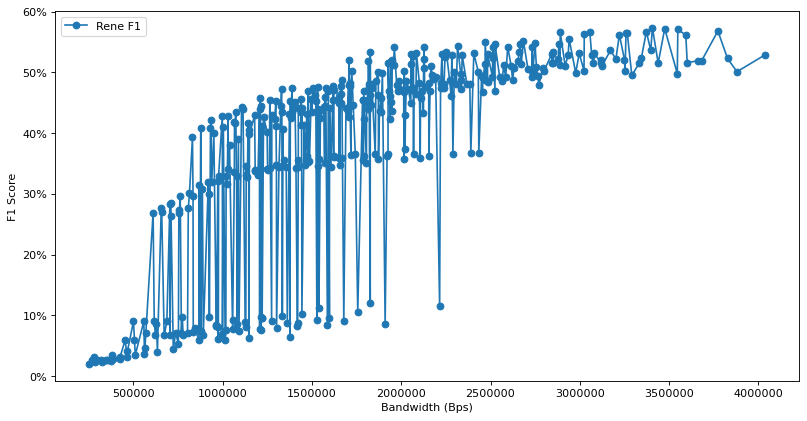

In [13]:
F1_Bandwidth_plot(bandwidth_f1)

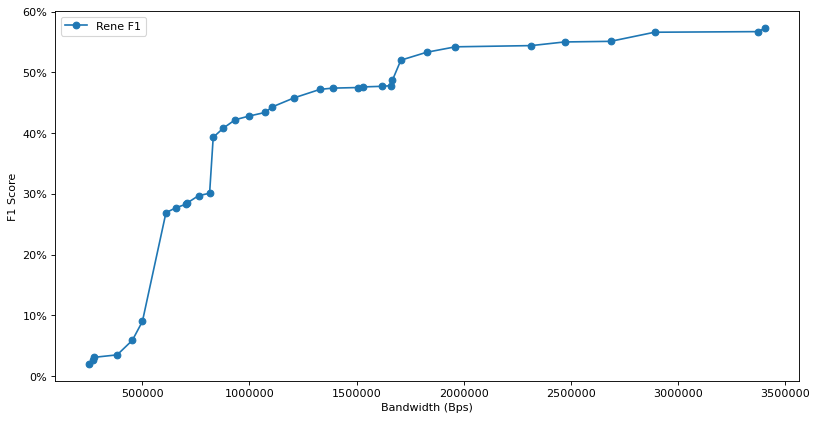

In [14]:
F1_Bandwidth_plot(bandwidth_f1_remove_fluc)